# Modelling count data with Tensoflow Probability

**Goal:** In this notebook you will again work with TFP. You will set up regression models that are able to output different conditional probability distributions to model count data. You will define different models with Keras, sklearn and the Tensorflow probability framework and optimize the negative log likelihood (NLL).
You compare the performace of the Poisson regression vs. the linear regression on a test dataset. Finally, you will extend the Poisson model to the zero-inflated Poisson model and compare the NLL of all models.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** 
You work with a camper dataset form https://stats.idre.ucla.edu/r/dae/zip/. The dataset contains data on 250 groups that went to a park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), if they used a live bait  and whether or not they brought a camper to the park (camper).
You split the data into train and test dataset.

**Content:**
* Work with different distributions in TFP: Normal, Poisson and zero-inflated Poisson
* Load and split the camper dataset 
* Fit different regression models to the camper train dataset: linar regression, Poisson regression and zero-inflated Poisson regression
* Plot the predicted probability distributions (CPD) for two specific datapoints along with their likelihood
* Plot the testdata along with the predicted mean and the 2.5% and 97.5% percentiles of the predicted CPD
* Compare the different models based on the test NLL 

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_05/nb_ch05_02.ipynb)


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
from matplotlib.axes import Axes
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from typing import *

tfd = tfp.distributions
tfb = tfp.bijectors
path = os.path.join(os.path.dirname(os.getcwd()), "data")

In [2]:
data = pd.read_csv(os.path.join(path, "fish.csv"))
print(data.info())
data[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nofish    250 non-null    int64  
 1   livebait  250 non-null    int64  
 2   camper    250 non-null    int64  
 3   persons   250 non-null    int64  
 4   child     250 non-null    int64  
 5   xb        250 non-null    float64
 6   zg        250 non-null    float64
 7   count     250 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 15.8 KB
None


,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [5]:
X, y = data.values[:, 1:5], data["count"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, data.shape, y_test[0:10], y_train[0:10]

((200, 4),
 (200,),
 (50, 4),
 (50,),
 (250, 8),
 array([0, 0, 2, 2, 0, 0, 0, 0, 1, 0], dtype=int64),
 array([ 6,  1,  6,  1,  3,  1,  0, 15,  0,  2], dtype=int64))

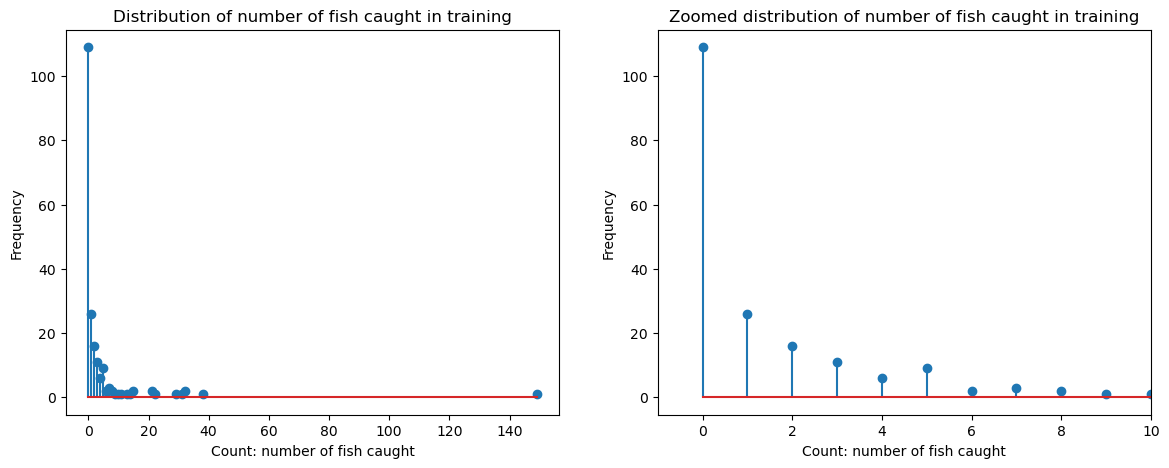

In [40]:
plt.figure(figsize=(14,5))

vals, counts = np.unique(y_train, return_counts=True)
plt.subplot(1, 2, 1)
plt.stem(vals, counts)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.title('Distribution of number of fish caught in training')

plt.subplot(1, 2, 2)
plt.stem(vals, counts)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.xlim(-1, 10)
plt.title('Zoomed distribution of number of fish caught in training')
plt.show()

You see that most of the groups didn't catch any fish at all. Most of the groups were not very successful, but there is one group that was very successful and caught 149 fish!

### Linear regression with sklearn 
 
Let's fist fit the linear regression with sklean on the training data.

In [41]:
model_skl = LinearRegression()
_ = model_skl.fit(X_train, y_train)

In [3]:
def get_variance_hat(y_train, y_pred):
    n = len(y_train)
    return (n - 1) / (n - 2) * np.var(y_train - y_pred, ddof=1)


def negative_log_likelihood(variance_hat, y_pred, y_true):
    return 0.5 * np.log(2 * np.pi * variance_hat) + 0.5 * np.mean((y_true - y_pred) ** 2) / variance_hat


def evaluate_model(model):
    y_hat_train = model.predict(X_train)
    n = len(X_train)
    variance_hat = get_variance_hat(y_train, y_hat_train)
    print('Estimated variance ', variance_hat)
    print('Estimated standart deviation ', np.sqrt(variance_hat))

    y_hat = model.predict(X_test) #Prediction on the testset
    RMSE_skl = np.std(y_hat - y_test)
    MAE_skl = np.mean(np.abs(y_test - y_hat)) 
    NLL_skl =  negative_log_likelihood(variance_hat, y_hat, y_test)
    print('NLL on training:', negative_log_likelihood(variance_hat, y_hat_train, y_train))

    print(f"RMSE: {RMSE_skl}\nMAE: {MAE_skl}\nNLL(mean): {NLL_skl}")

In [43]:
evaluate_model(model_skl)

Estimated variance  118.45401800694137
Estimated standart deviation  10.883658300725054
NLL on training: 3.801200958991639
RMSE: 8.572065305350751
MAE: 4.705090187709163
NLL(mean): 3.6175281561416703


### Linear regression with Keras 
 
Let's do the same as before with sklearn, but this time you fit a linear regression  model with keras.
You have 4 inputs (child , persons livebait, camper) and 1 output (count). Note that you'll use the standart MSE loss.

In [57]:
model_lr = Sequential()
model_lr.add(Dense(1, input_dim=X_train.shape[1], activation='linear')) 
model_lr.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))
model_lr.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [58]:
hist_lr = model_lr.fit(X_train, y_train[:, None], validation_data=(X_test, y_test[:, None]), epochs=5000, verbose=0, batch_size=len(y_train))

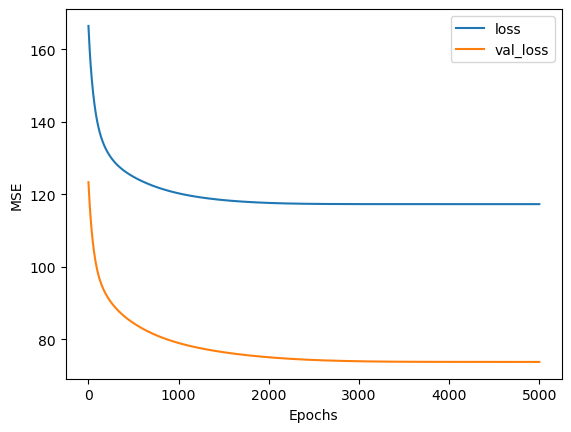

In [59]:
plt.plot(hist_lr.history['loss'])  # Note this is the MSE and not the RMSE
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [60]:
evaluate_model(model_lr)

Estimated variance  169.42388500782315
Estimated standart deviation  13.016293059386115
NLL on training: 3.982615418186549
RMSE: 11.107499414388508
MAE: 6.065704442596435
NLL(mean): 3.8500599139243197


In [61]:
print('weights using deep learning:          ',model_lr.get_weights()[0][:,0])
print('weights from sklearn:                 ',model_skl.coef_)
print('Intercept (bias) using deep learning: ',model_lr.get_weights()[1][0])
print('Intercept (bias) using sklearn:       ',model_skl.intercept_)

weights using deep learning:           [ 2.4821596  2.9542983  4.6495233 -5.4715915]
weights from sklearn:                  [ 2.4822138   2.95430727  4.64953914 -5.47160051]
Intercept (bias) using deep learning:  -8.492138
Intercept (bias) using sklearn:        -8.492228208419727


Let's plot the observed values vs the predicted mean of caught fish on the test dataset. To inicate the CPD you also plot  the 2.5% and 97.5% percentiles of the predicted CPD. You highlight the observations 31 and 33.

In [110]:
variance_hat = get_variance_hat(y_train, model_lr.predict(X_train))
sigma = np.sqrt(variance_hat)
sigma

13.016293059386115

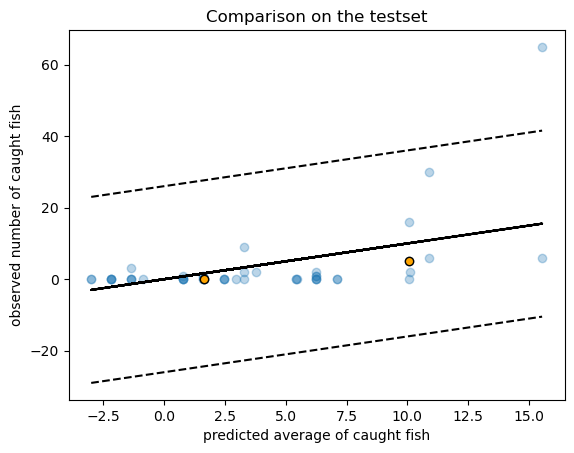

In [112]:
y_hat_test = model_lr.predict(X_test).flatten()
plt.scatter(y_hat_test, y_test, alpha=0.3)
for index in [31, 33]:
    plt.scatter(y_hat_test[index], y_test[index], c="orange", marker='o', edgecolors= "black")
sort_idx = np.argsort(y_hat_test, axis=0)
plt.plot(y_hat_test[sort_idx], y_hat_test[sort_idx] + 2 * sigma, linestyle='dashed', c="black")
plt.plot(y_hat_test[sort_idx], y_hat_test[sort_idx] - 2 * sigma, linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.show()

In [65]:
# Let's check the mean of the predicted CPDs for the obeservations nr 31 and 33
print(y_hat_test[31])
print(y_hat_test[33])
# Remember the observed nr of caught fish for the obeservations nr 31 and 33
print(y_test[31])
print(y_test[33])

10.070822
1.6449327
5
0


Lets check the predicted outcome distribution for the observations 31 and 33.

In [108]:
def plot_normal_distribution_for_observation(sigma: float, y_pred: float, y_true: float, ax: Axes, title: str) -> Axes:
    dist = ss.norm(loc=y_pred, scale=sigma)
    x = np.arange(-40, 40, 0.1)
    y = dist.pdf(x)
    ax.plot(x, y)
    ax.vlines(y_pred, ymin=0, ymax=dist.pdf(y_pred), linestyle='dashed')
    ax.vlines(y_true, ymin=0, ymax=dist.pdf(y_true), linestyle='dotted', color="purple", linewidth=2)
    ax.set_xlabel("Number of Events")
    ax.set_ylabel("Prob. Density")
    ax.set_title(title)
    return ax

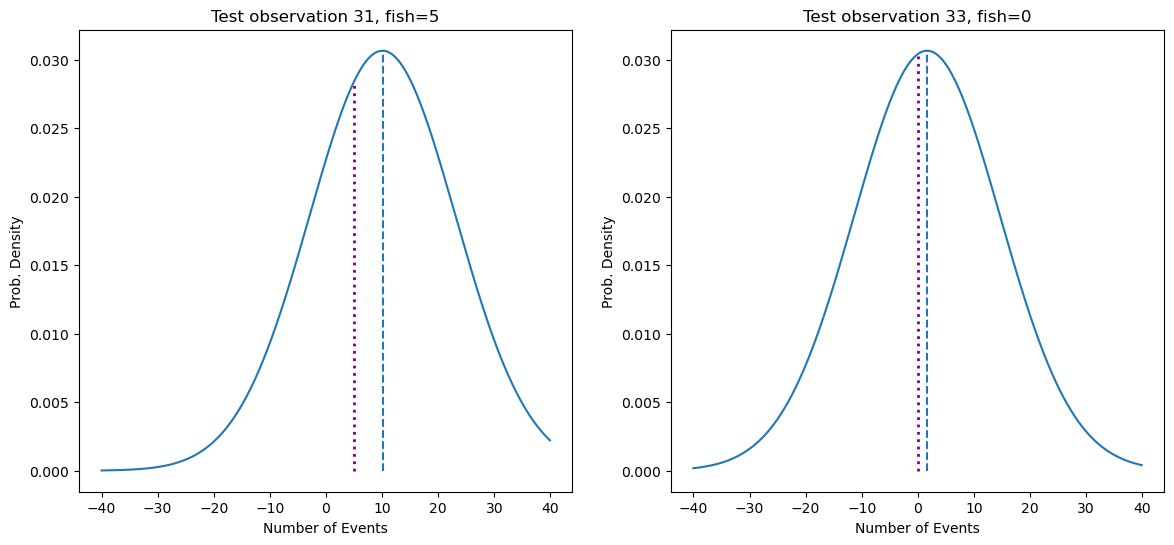

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

for i, index in enumerate([31, 33]):
    ax = axes[i]
    y_pred = y_hat_test[index]
    y_true = y_test[index]
    plot_normal_distribution_for_observation(sigma, y_pred, y_true, ax, f"Test observation {index}, fish={y_true}")

plt.show()

You can see that the liklihood of the observed values are quite high under the predicted CPDs (dotted line). However, note that the linear model predicts also negative values, which is obviously wrong. 

## Poisson Regression 

Now you use  the TFP framework and the Poission distribution to model the output of the network as a Poissonian CPD. You will not use any hidden layers in between and the loss will be the NLL. After the fitting, you predict the test data and compare the performance with the linear regression model.
$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

#### Listing 5.6: Simple Poisson regression for the number of fish caught 


In [95]:
inputs = Input(shape=(X_train.shape[1]))  
rate = Dense(1, activation="exponential")(inputs)
dist = tfp.layers.DistributionLambda(lambda t: tfd.Poisson(rate=t, force_probs_to_zero_outside_support=True))(rate)
model_poisson = Model(inputs=inputs, outputs=dist)


def NLL(y_true, dist):
  return -dist.log_prob(y_true)

model_poisson.compile(Adam(learning_rate=0.01), loss=NLL)
model_poisson.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
 distribution_lambda_2 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [96]:
hist_poisson = model_poisson.fit(X_train, y_train.astype("float32"), validation_data=(X_test, y_test.astype("float32")), epochs=2000, verbose=0, batch_size=len(X_train))

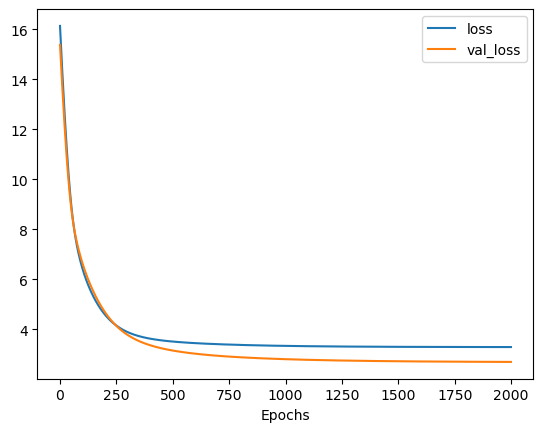

In [97]:
plt.plot(hist_poisson.history['loss'])
plt.plot(hist_poisson.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [104]:
y_hat_test = model_poisson(X_test).mean().numpy().flatten()

rmse = np.sqrt(np.mean((y_test - y_hat_test)**2))
mae = np.mean(np.abs(y_test - y_hat_test)) 

nll = model_poisson.evaluate(X_test, y_test.astype("float32")) #returns the NLL 
print(f"RMSE: {rmse}\nMAE: {mae}\nNLL(mean): {nll}")

2/2 [==============================] - 0s 0s/step - loss: 2.7040
RMSE: 7.204012106781236
MAE: 3.1187860763072965
NLL(mean): 2.7039525508880615


 the Poisson regression outperform the linear regression because of the lower NLL.

Let's plot the observed values vs the predicted mean of caught fish on the test dataset. To inicate the CPD you also plot the 2.5% and 97.5% percentiles of the predicted CPD. You highlight the observations 31 and 33.

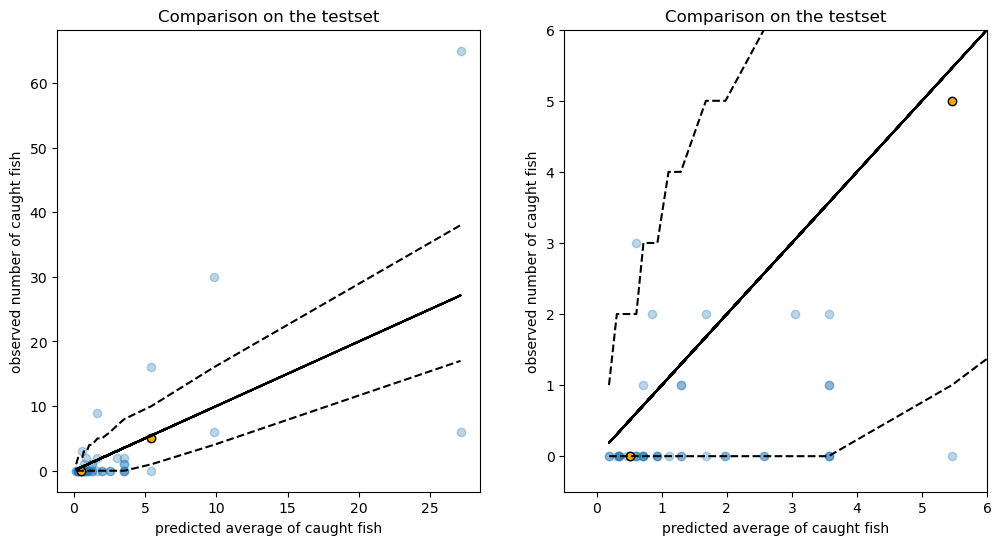

In [106]:
lower = ss.poisson.ppf(0.025, y_hat_test)
upper = ss.poisson.ppf(0.975, y_hat_test)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33], c="orange", marker='o', edgecolors="black")
plt.scatter(y_hat_test[31], y_test[31], c="orange", marker='o', edgecolors="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')

sort_idx = np.argsort(y_hat_test)
plt.plot(y_hat_test[sort_idx], lower[sort_idx], linestyle='dashed', c="black")
plt.plot(y_hat_test[sort_idx], upper[sort_idx], linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")


plt.subplot(1, 2, 2)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33], c="orange", marker='o', edgecolors="black")
plt.scatter(y_hat_test[31], y_test[31], c="orange", marker='o', edgecolors="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')

sort_idx = np.argsort(y_hat_test)
plt.plot(y_hat_test[sort_idx], lower[sort_idx], linestyle='dashed', c="black")
plt.plot(y_hat_test[sort_idx], upper[sort_idx], linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.xlim([-0.5, 6])
plt.ylim([-0.5, 6])

plt.show()

In [107]:
# Let's check the mean of the predicted CPDs for the obeservations nr 31 and 33
print(y_hat_test[31])
print(y_hat_test[33])
# Remember the observed nr of caught fish for the obeservations nr 31 and 33
print(y_test[31])
print(y_test[33])

5.459082
0.5171593
5
0


Lets check the predicted outcome distribution for the observations 31 and 33.

In [124]:
def plot_poisson_distribution_for_observation(model: Model, X: np.ndarray, y: int, ax: Axes, title: str) -> Axes:
    x = np.arange(0, 20, 1)
    X = X.reshape(1, -1)
    probs = K.exp(model(X).log_prob(x)).numpy().flatten()
    ax.stem(x, probs)
    ax.vlines(y, ymin=0, ymax=probs[y], linestyle='dashed', color="purple", linewidth=4)
    ax.set_xlabel("Number of Events")
    ax.set_ylabel("Prob.")
    ax.set_title(title)
    return ax

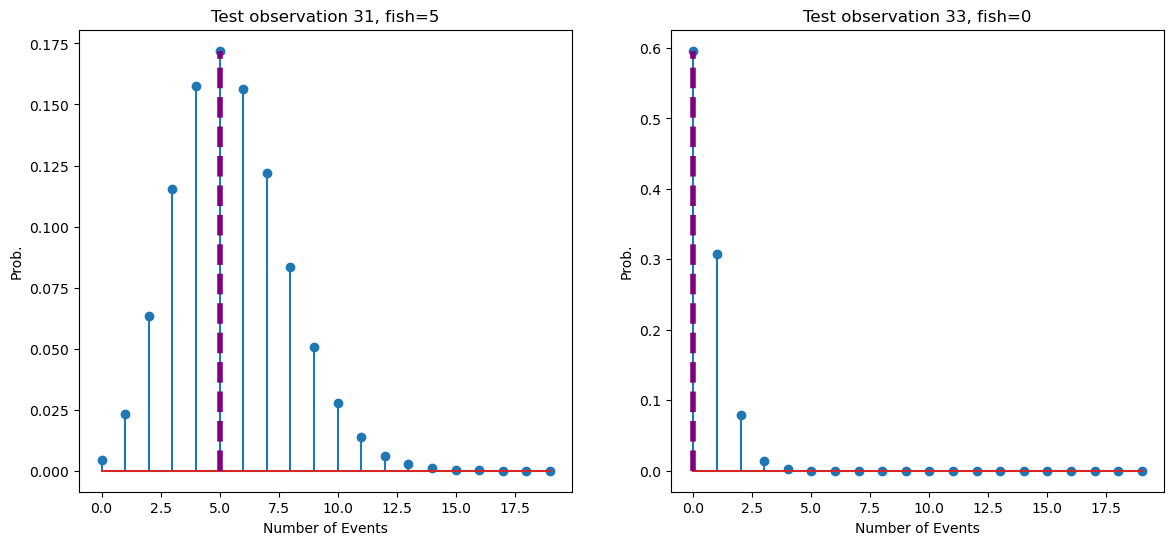

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

for i, index in enumerate([31, 33]):
    ax = axes[i]
    X = X_test[index]
    y = y_test[index]
    plot_poisson_distribution_for_observation(model_poisson, X, y, ax, f"Test observation {index}, fish={y}")

plt.show()

You can see that the liklihood of the observed values are quite high under the predicted CPDs (dotted line). Note that the Poisson CPD does only predict non-negative integer values which is a quite nice property for count data.

## Zero-inflate Poisson

In [14]:
inputs = Input(shape=(X_train.shape[1]))  
out = Dense(2)(inputs)

def zero_inf(out):
    rate = K.exp(out[:, 0])
    s = K.sigmoid(out[:, 1:2])
    probs = tf.concat([1 - s, s], axis=1)
    return tfd.Mixture(
        cat=tfd.Categorical(probs=probs), 
        components=[tfd.Deterministic(loc=K.zeros_like(rate)), tfd.Poisson(rate=rate, force_probs_to_zero_outside_support=True)])

dist = tfp.layers.DistributionLambda(zero_inf)(out)
model_zip = Model(inputs=inputs, outputs=dist)


def NLL(y_true, dist):
  return -dist.log_prob(y_true)

model_zip.compile(Adam(learning_rate=0.01), loss=NLL)
model_zip.summary()

Instructions for updating:
The `interpolate_nondiscrete` property is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 10        
                                                                 
 distribution_lambda_7 (Dist  ((None,),                0         
 ributionLambda)              (None,))                           
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [16]:
hist_zip = model_zip.fit(X_train, y_train.astype("float32"), validation_data=(X_test, y_test.astype("float32")), epochs=2000, verbose=0, batch_size=len(X_train))

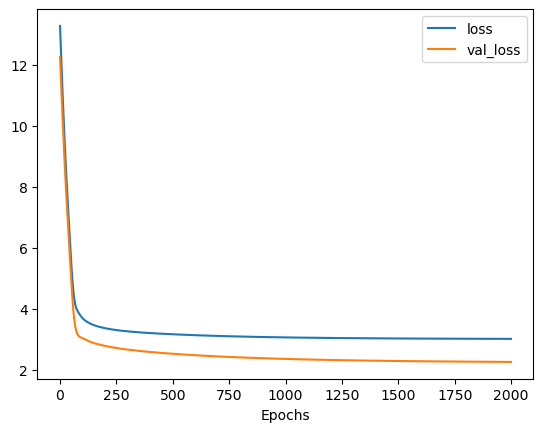

In [17]:
plt.plot(hist_zip.history['loss'])
plt.plot(hist_zip.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [19]:
y_hat_test = model_zip(X_test).mean().numpy().flatten()

rmse = np.sqrt(np.mean((y_test - y_hat_test)**2))
mae = np.mean(np.abs(y_test - y_hat_test)) 

nll = model_zip.evaluate(X_test, y_test.astype("float32")) #returns the NLL 
print(f"RMSE: {rmse}\nMAE: {mae}\nNLL(mean): {nll}")

2/2 [==============================] - 0s 0s/step - loss: 2.2627
RMSE: 7.347429396327077
MAE: 3.192177391350269
NLL(mean): 2.2627344131469727


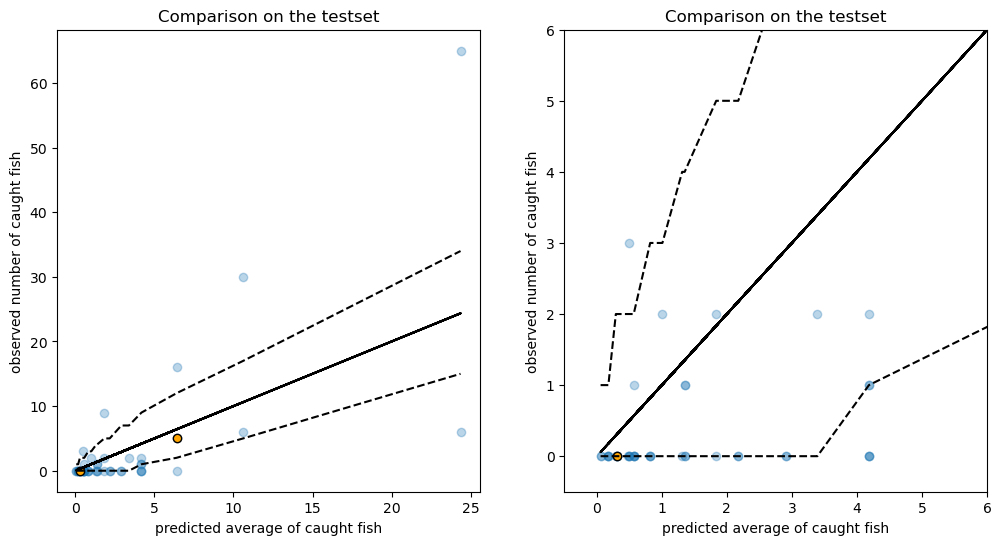

In [20]:
lower = ss.poisson.ppf(0.025, y_hat_test)
upper = ss.poisson.ppf(0.975, y_hat_test)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33], c="orange", marker='o', edgecolors="black")
plt.scatter(y_hat_test[31], y_test[31], c="orange", marker='o', edgecolors="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')

sort_idx = np.argsort(y_hat_test)
plt.plot(y_hat_test[sort_idx], lower[sort_idx], linestyle='dashed', c="black")
plt.plot(y_hat_test[sort_idx], upper[sort_idx], linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")


plt.subplot(1, 2, 2)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33], c="orange", marker='o', edgecolors="black")
plt.scatter(y_hat_test[31], y_test[31], c="orange", marker='o', edgecolors="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')

sort_idx = np.argsort(y_hat_test)
plt.plot(y_hat_test[sort_idx], lower[sort_idx], linestyle='dashed', c="black")
plt.plot(y_hat_test[sort_idx], upper[sort_idx], linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.xlim([-0.5, 6])
plt.ylim([-0.5, 6])

plt.show()